In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import numpy as np
import os

In [27]:
# Read the CSV file
read_data = pd.read_csv("D:\\CMU_NML\\Mindrove_venv\\xvcv.csv")
df_data = pd.DataFrame(read_data)


In [28]:
num_channels = df_data[df_data.columns[:8]].shape[1]
num_channels

8

In [13]:
def notch_filter(data, f0=60.0, fs=500, Q=30):
    """Applies a notch filter to the data to remove 60 Hz interference."""
    b, a = iirnotch(f0, Q, fs)
    return filtfilt(b, a, data)

In [14]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    """Designs a Butterworth bandpass filter."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [15]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    """Applies a Butterworth bandpass filter to the data."""
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, data)

In [16]:
def calc_rms_value(filt_data):
    pd_filt_data= pd.DataFrame(filt_data)
    print(pd_filt_data)
    rms_values = []
    for channel in pd_filt_data.columns:
        rms = np.sqrt(np.mean(pd_filt_data[channel]**2))  # RMS
        rms_values.append(rms)
    return rms_values

In [25]:
from scipy.signal import butter, filtfilt, iirnotch
import numpy as np

class SignalProcessor:
    """Class for applying signal processing techniques to EEG data."""
    def __init__(self, fs, highpass_cutoff=1.0, notch_freq=60.0, notch_q=30, highpass_order=4):
        self.fs = fs
        self.highpass_cutoff = highpass_cutoff
        self.notch_freq = notch_freq
        self.notch_q = notch_q
        self.highpass_order = highpass_order

        # Design the filters
        self.b_high, self.a_high = self._design_highpass_filter()
        self.b_notch, self.a_notch = self._design_notch_filter()

    def _design_highpass_filter(self):
        """Design a high-pass filter using Butterworth filter."""
        nyquist = 0.5 * self.fs
        normal_cutoff = self.highpass_cutoff / nyquist
        b, a = butter(self.highpass_order, normal_cutoff, btype='high', analog=False)
        return b, a

    def _design_notch_filter(self):
        """Design a notch filter to remove a specific frequency."""
        b, a = iirnotch(self.notch_freq, self.notch_q, self.fs)
        return b, a

    def _apply_filter(self, data, b, a):
        """Apply the given filter to each channel individually using matrix operations."""
        # Apply the filter along axis 1 (time axis) for each channel individually
        filtered_data = np.apply_along_axis(lambda x: filtfilt(b, a, x), axis=1, arr=data)
        return filtered_data

    def apply_highpass_filter(self, data):
        """Apply the high-pass filter to the data for all channels individually."""
        return self._apply_filter(data, self.b_high, self.a_high)

    def apply_notch_filter(self, data):
        """
        Apply the notch filter to the data for all channels individually."""
        return self._apply_filter(data, self.b_notch, self.a_notch)

    def preprocess(self, data):
        """
        Preprocess the data by applying the high-pass filter and the notch filter."""
        # Apply notch filter
        data = self.apply_notch_filter(data)
        # Apply high-pass filter
        data = self.apply_highpass_filter(data)
        return data


In [31]:
def process_single_session(file_path, num_channels, fs):
    df_data = pd.read_csv(file_path)

    filtered_signals = []
    for i in range(num_channels):
        channel_data = df_data.iloc[:, i].values
        bandpassed_data = bandpass_filter(channel_data, lowcut=10, highcut=225, fs=fs)
        filtered_data = notch_filter(bandpassed_data, f0=60, fs=fs)
        filtered_signals.append(filtered_data)

    # Convert the filtered signals to a DataFrame
    filtered_df = pd.DataFrame(filtered_signals).T
    filtered_df.columns = [f"Channel {i+1}" for i in range(num_channels)]

    # Plot the filtered signals
    fig, axes = plt.subplots(num_channels, 1, figsize=(10, 12), sharex=True)
    fig.suptitle("Filtered EMG Data (10-225 Hz Bandpass and 60 Hz Notch)", fontsize=16)

    for i in range(num_channels):
        axes[i].plot(filtered_df.iloc[:, i], label=f'Channel {i + 1}', linewidth=0.7)
        axes[i].set_title(f'Channel {i + 1}')
        axes[i].set_ylabel("Amplitude")
        axes[i].grid(True)
        axes[i].legend()
        axes[i].relim()
        axes[i].autoscale_view()

    axes[-1].set_xlabel("Time Points")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return filtered_df

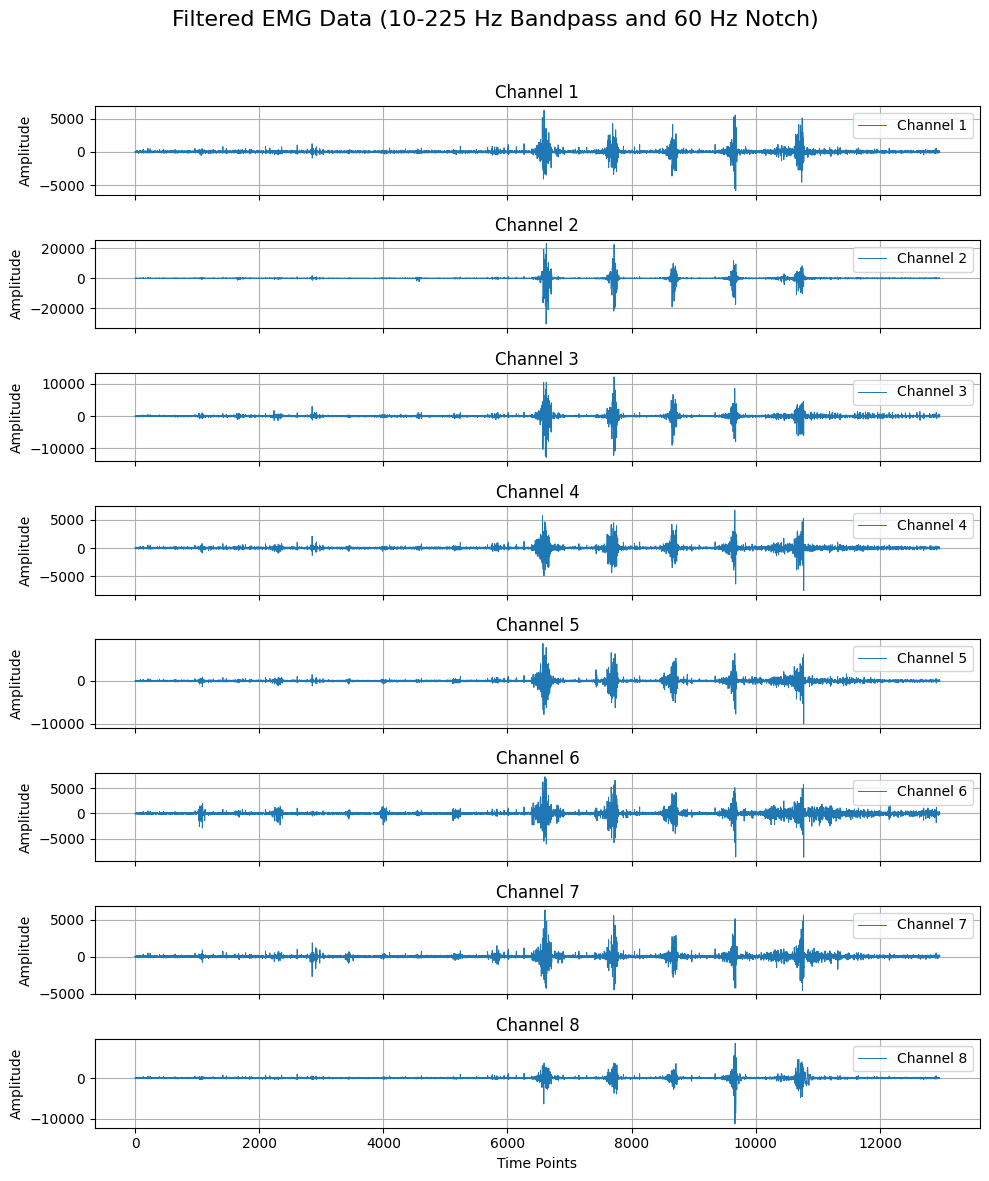

In [33]:
# filtered_data = process_single_session("D:\\CMU_NML\\Mindrove_venv\\mindrove_data_16_1_2025\\Session_2_1.csv", 8, 500)
filtered_data = process_single_session("D:\\CMU_NML\\Mindrove_venv\\new_sp.csv", 8, 500)

In [190]:
def calculate_rms(filtered_df):
    rms_values = {}
    for column in filtered_df.columns:
        rms_values[column] = np.sqrt(np.mean(filtered_df[column] ** 2))
    
    return rms_values

rms_values = calculate_rms(filtered_data)
print("RMS values for each channel:", rms_values)


RMS values for each channel: {'Channel 1': np.float64(470.557733322994), 'Channel 2': np.float64(673.5199880207415), 'Channel 3': np.float64(653.3511211398109), 'Channel 4': np.float64(287.4959938826336), 'Channel 5': np.float64(240.28487065242416), 'Channel 6': np.float64(221.72851598278035), 'Channel 7': np.float64(140.97022402839505), 'Channel 8': np.float64(280.07770781533173)}


In [193]:
def process_multiple_sessions(pri_path, session_list, num_channels, fs):
    all_rms_values = {}

    for session in session_list:
        file_path = os.path.join(pri_path, session)  # Update with actual path structure
        filtered_df = process_single_session(file_path, num_channels, fs)  # Process the session data
        rms_values = calculate_rms(filtered_df)  # Calculate RMS for the session
        all_rms_values[session] = rms_values  # Store RMS values for this session
    
    return all_rms_values

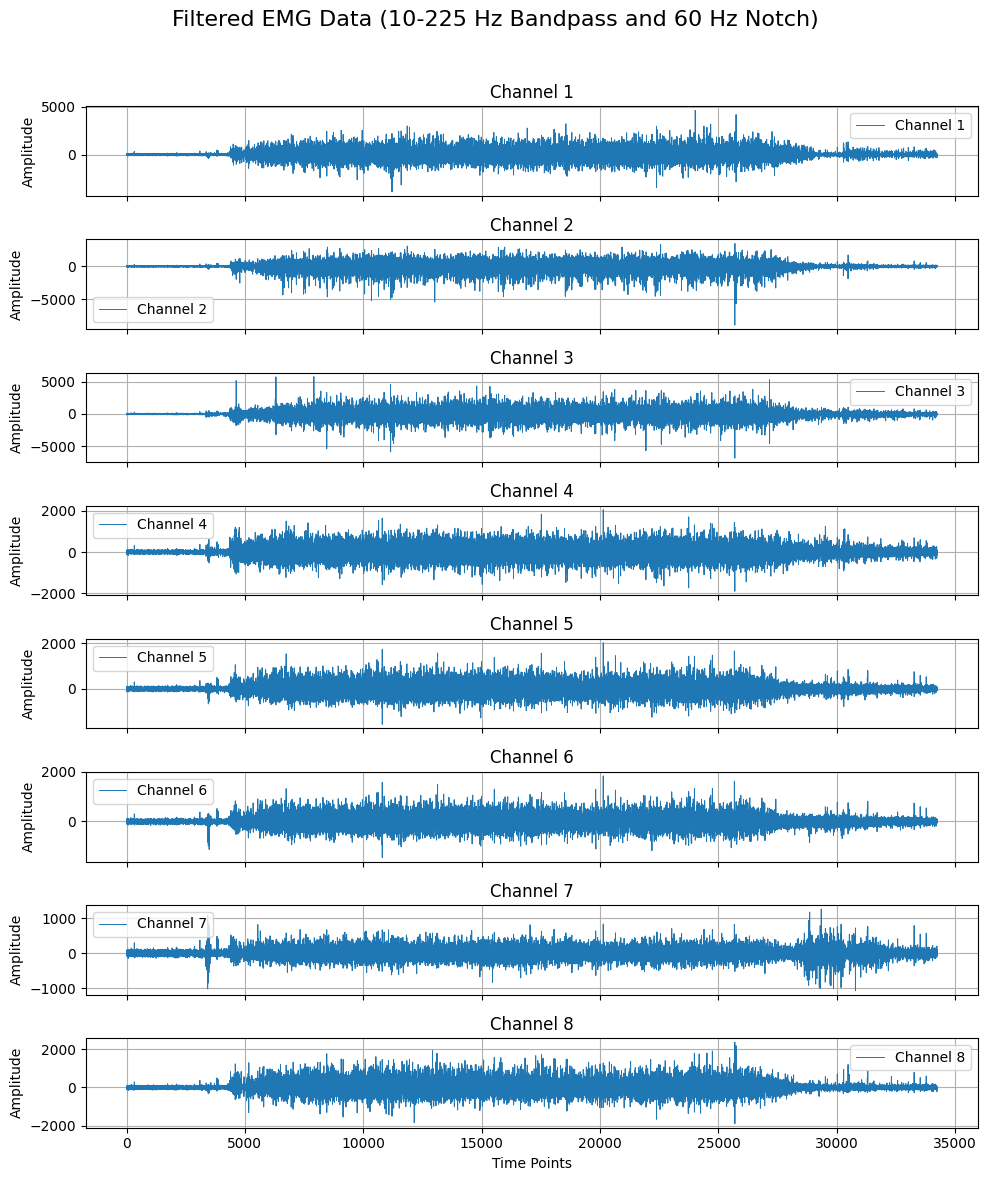

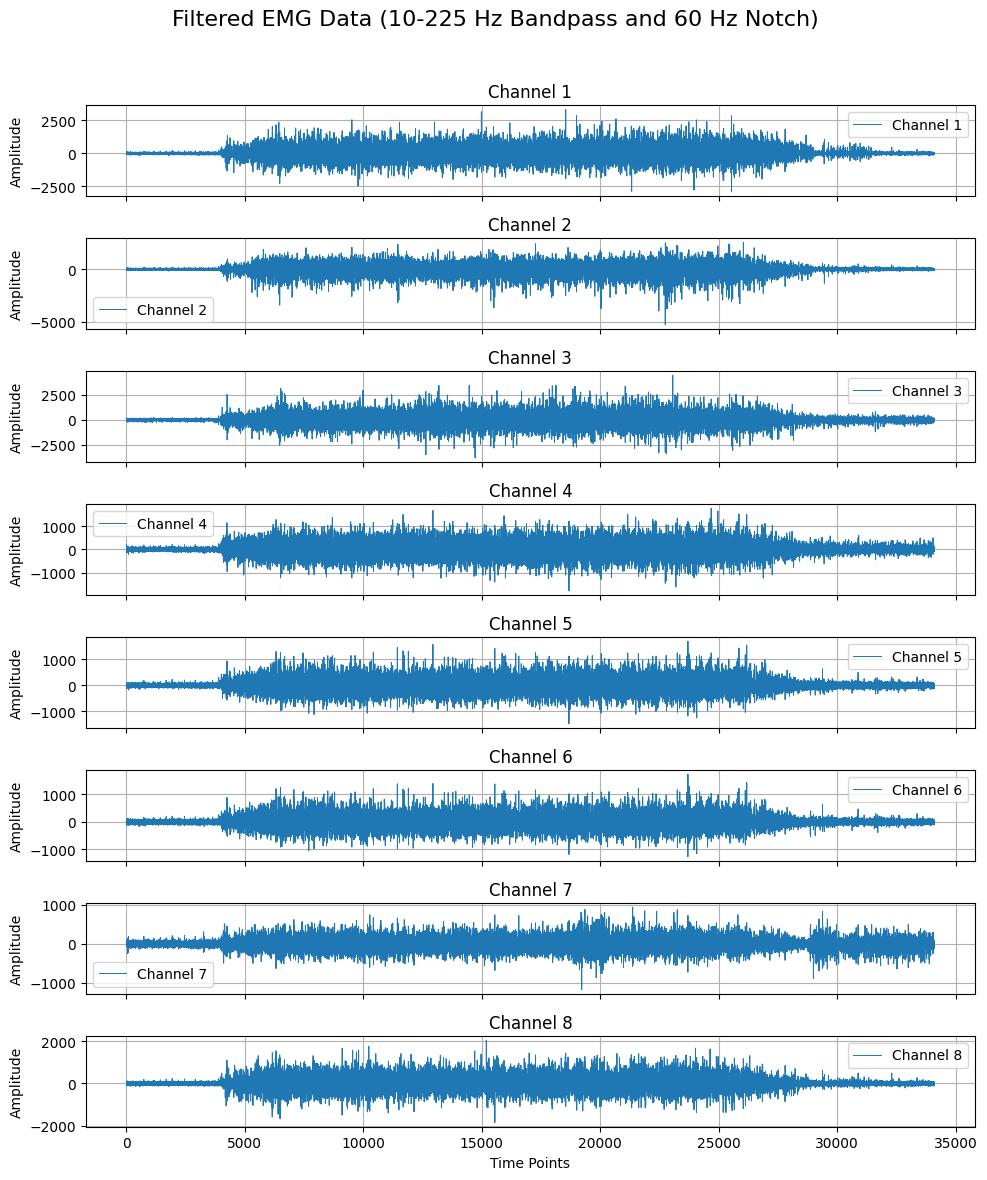

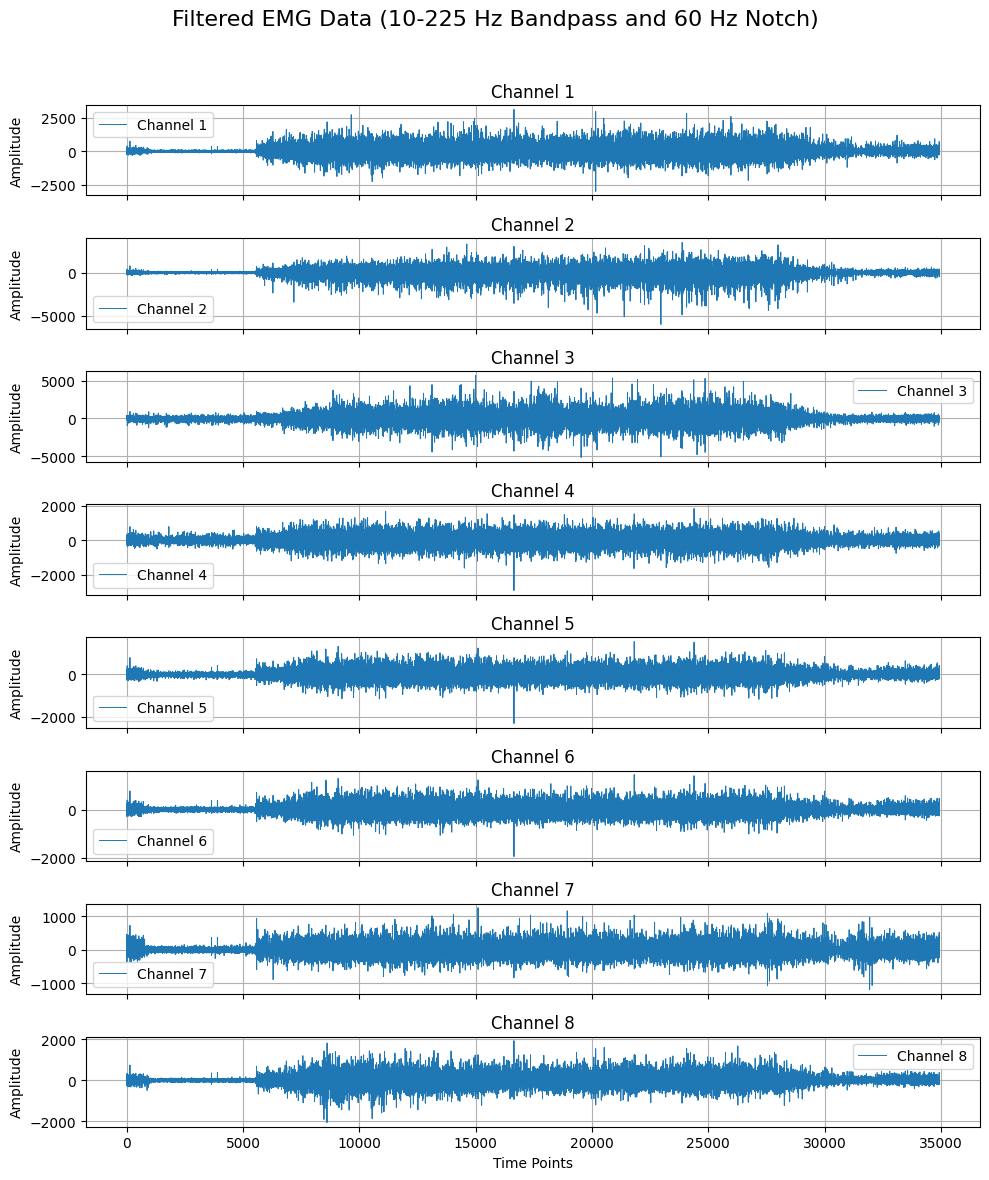

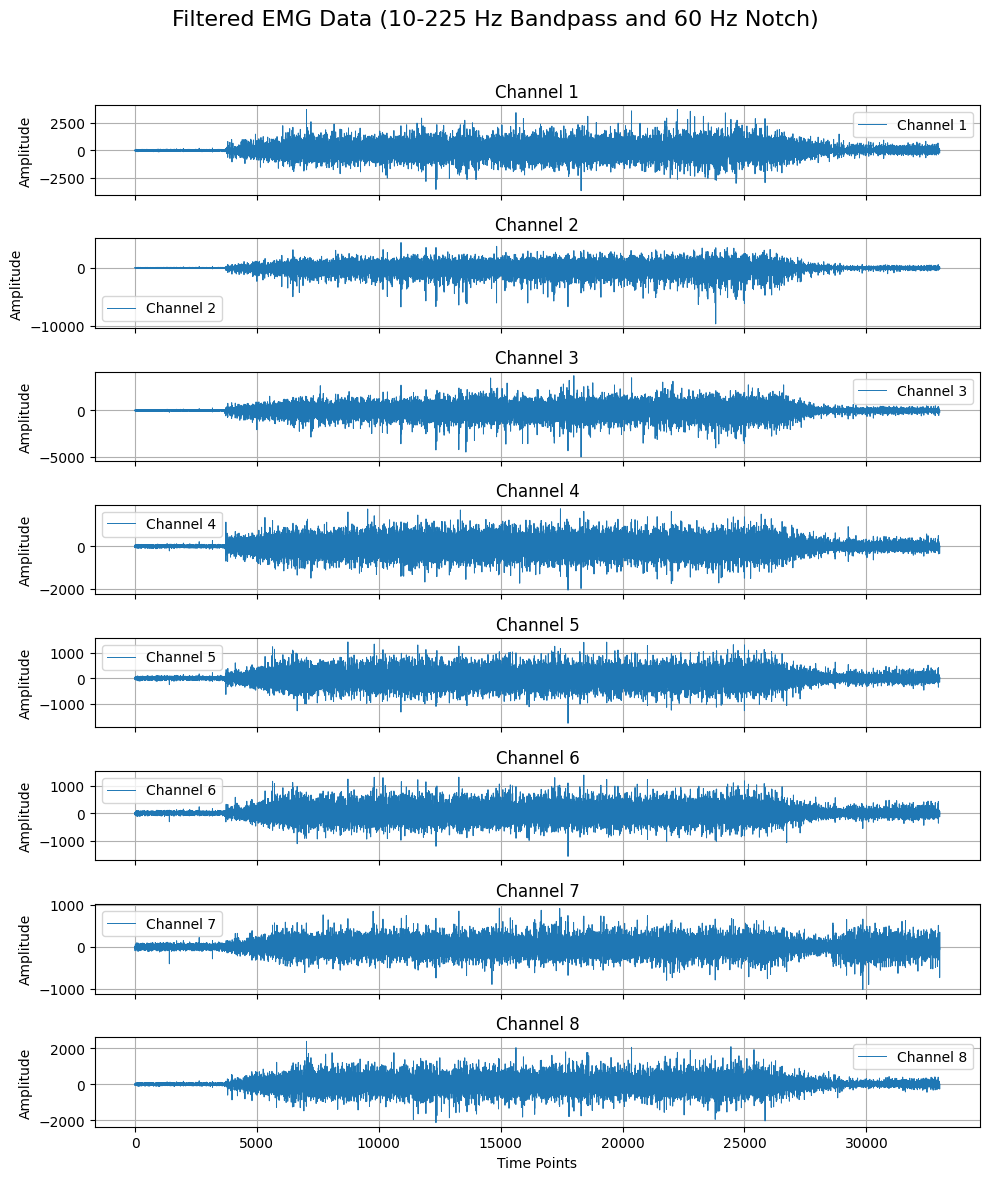

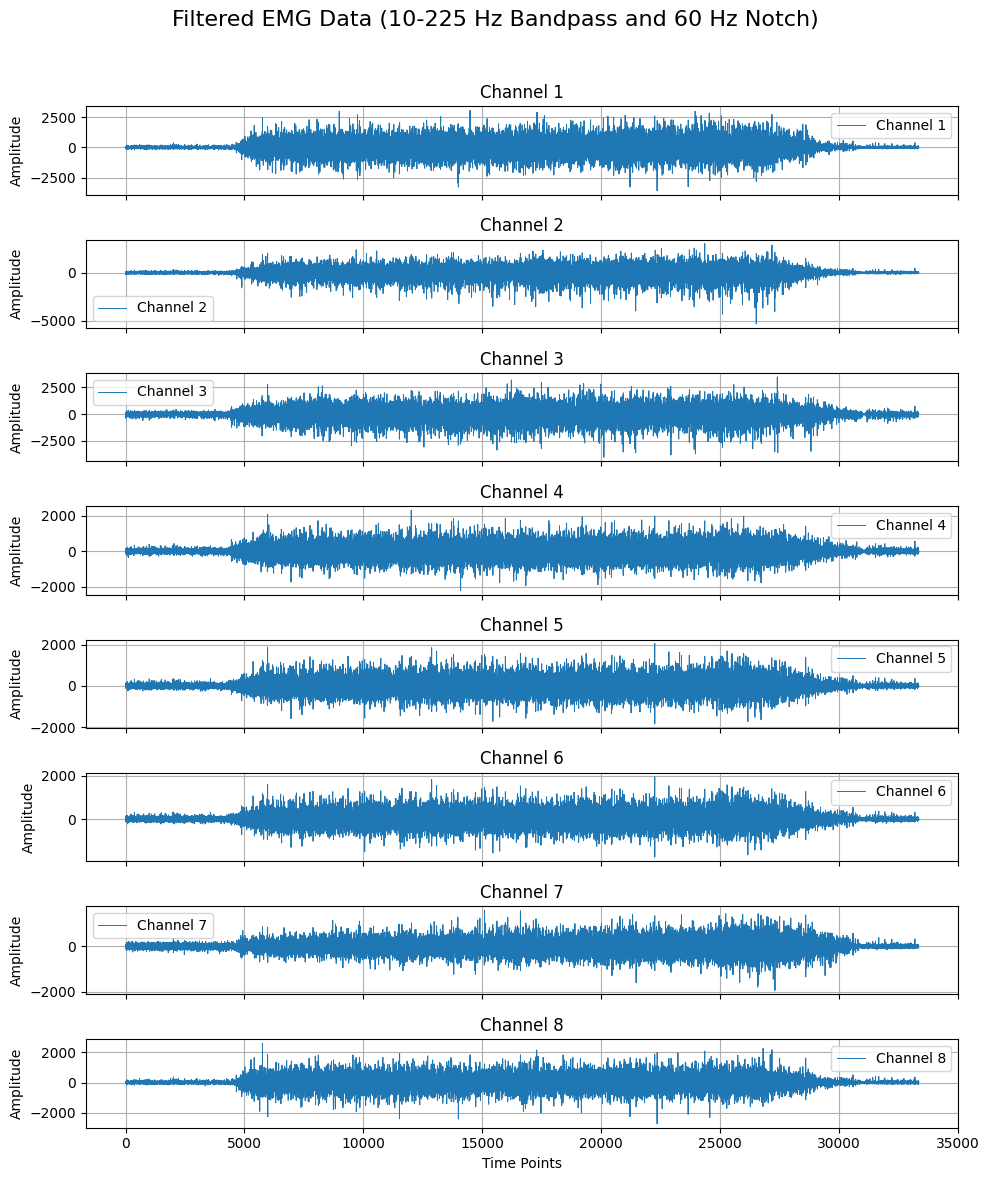

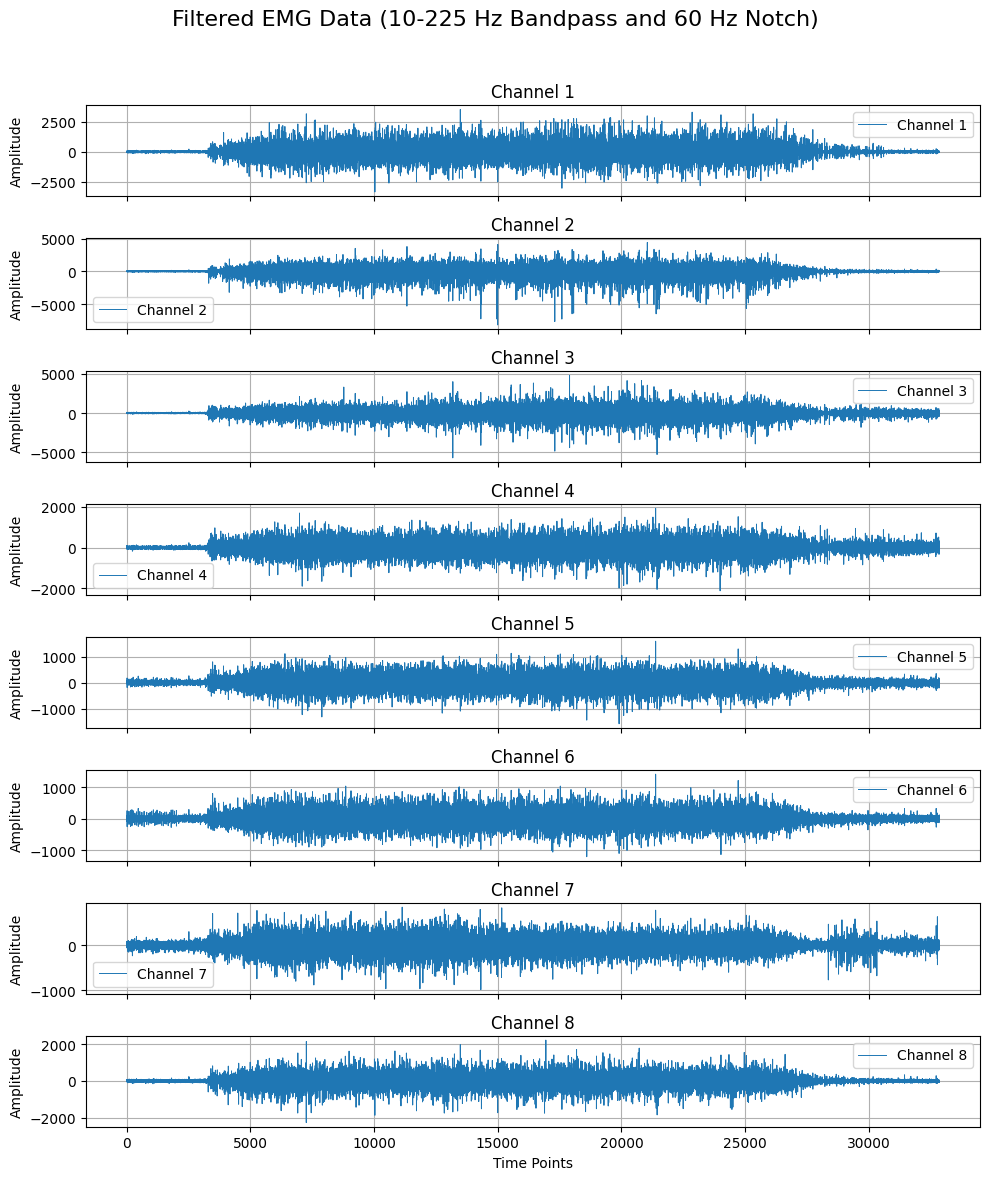

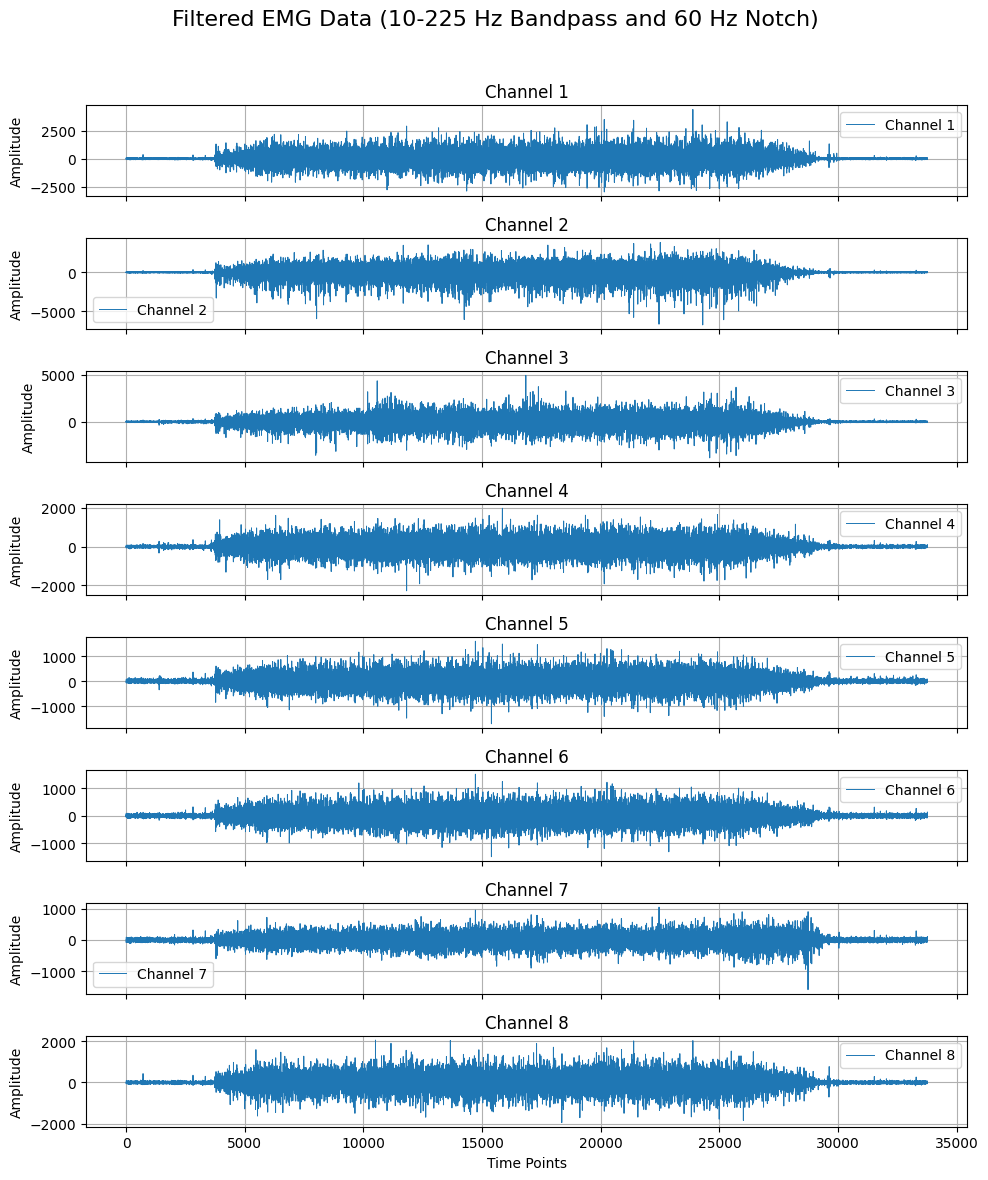

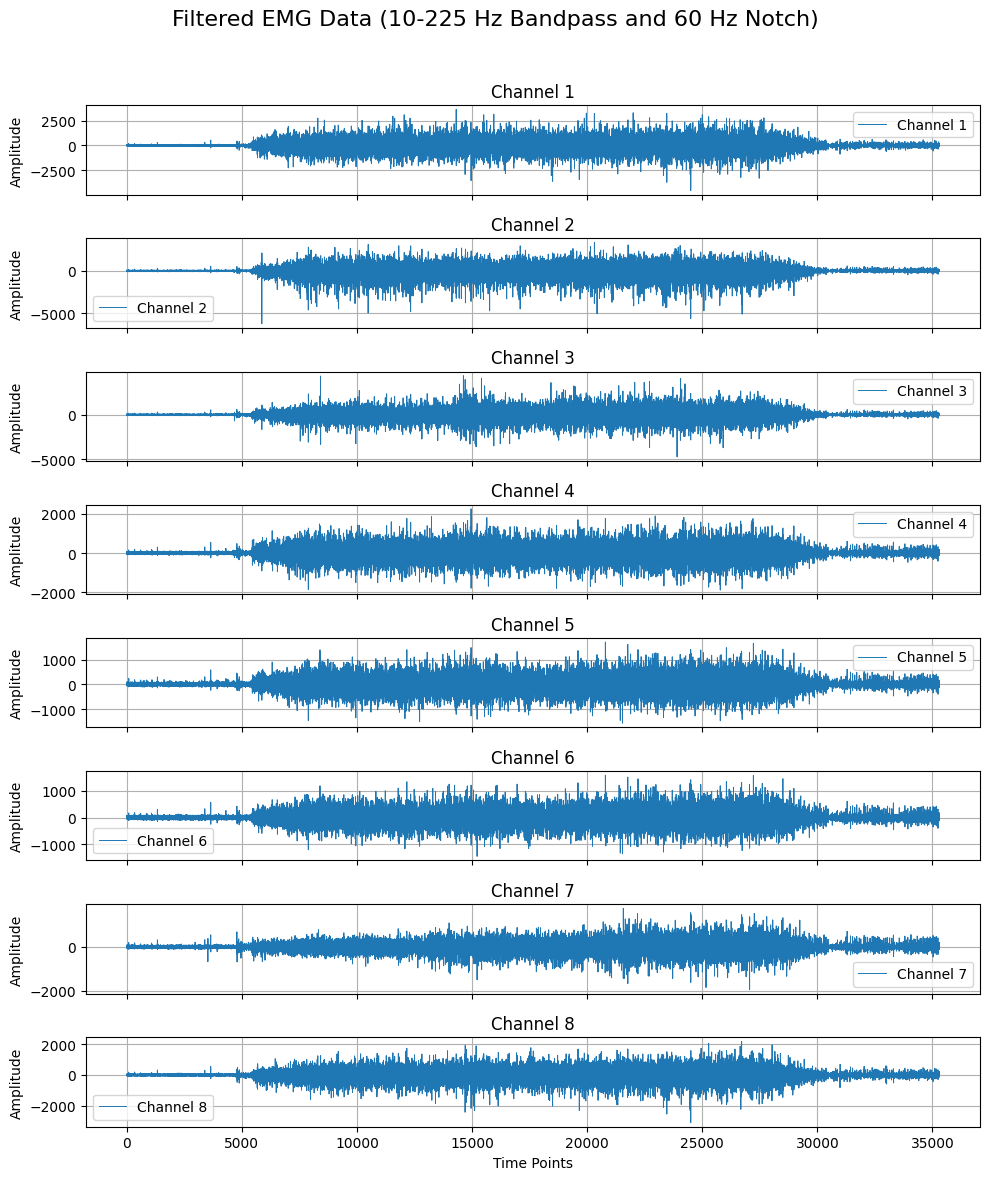

RMS values for Session_2_1.csv:
  Channel 1: 470.557733322994
  Channel 2: 673.5199880207415
  Channel 3: 653.3511211398109
  Channel 4: 287.4959938826336
  Channel 5: 240.28487065242416
  Channel 6: 221.72851598278035
  Channel 7: 140.97022402839505
  Channel 8: 280.07770781533173
RMS values for Session_2_2.csv:
  Channel 1: 441.716802578716
  Channel 2: 475.0593425061612
  Channel 3: 528.3421447892953
  Channel 4: 284.1721791949444
  Channel 5: 242.9058697198328
  Channel 6: 222.54942213378848
  Channel 7: 144.72323815944412
  Channel 8: 288.6963132194978
RMS values for Session_2_4.csv:
  Channel 1: 399.83715879990905
  Channel 2: 592.327131705783
  Channel 3: 707.3559448733937
  Channel 4: 302.0060498793071
  Channel 5: 232.21114198050319
  Channel 6: 211.34640123585683
  Channel 7: 175.84607954277348
  Channel 8: 264.77041719464887
RMS values for Session_2_5.csv:
  Channel 1: 521.0998820568407
  Channel 2: 791.0211496603755
  Channel 3: 569.2065566771272
  Channel 4: 309.6507838987

In [194]:
# Example usage
prim_path = "D:\\CMU_NML\\Mindrove_venv\\mindrove_data_16_1_2025\\"
day2_exp_list = [
    'Session_2_1.csv',
    'Session_2_2.csv',
    # 'Session_2_3.csv',
    'Session_2_4.csv',
    'Session_2_5.csv',
    # 'Session_2_6.csv',
    'Session_2_7.csv',
    'Session_2_8.csv',
    'Session_2_9.csv',
    # 'Session_2_10.csv',
    'Session_2_11.csv'
]
rms_results = process_multiple_sessions(prim_path, day2_exp_list, num_channels, 500)

# Print the RMS values for each session
for session, rms_values in rms_results.items():
    print(f"RMS values for {session}:")
    for channel, rms in rms_values.items():
        print(f"  {channel}: {rms}")


In [203]:
def plot_rms_values(rms_results):
    rms_df = pd.DataFrame(rms_results).T  
    rms_df = rms_df.sort_index(axis=1) 

    rms_df.plot(kind='bar', figsize=(12, 6), width=0.8)
    plt.title('RMS Values for Each Channel Across Sessions', fontsize=16)
    plt.xlabel('Sessions', fontsize=12)
    plt.ylabel('RMS Value', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Channels', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [207]:
def plot_rms_values(rms_results):
    rms_df = pd.DataFrame(rms_results).T  
    rms_df = rms_df.sort_index(axis=1)  

    # Plot the RMS values
    plt.figure(figsize=(12, 6))
    for channel in rms_df.columns:
        plt.plot(rms_df.index, rms_df[channel], marker='o', label=f'{channel}')
    
    plt.title('RMS Values for Each Channel Across Sessions', fontsize=16)
    plt.xlabel('Sessions', fontsize=12)
    plt.ylabel('RMS Value', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Channels', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


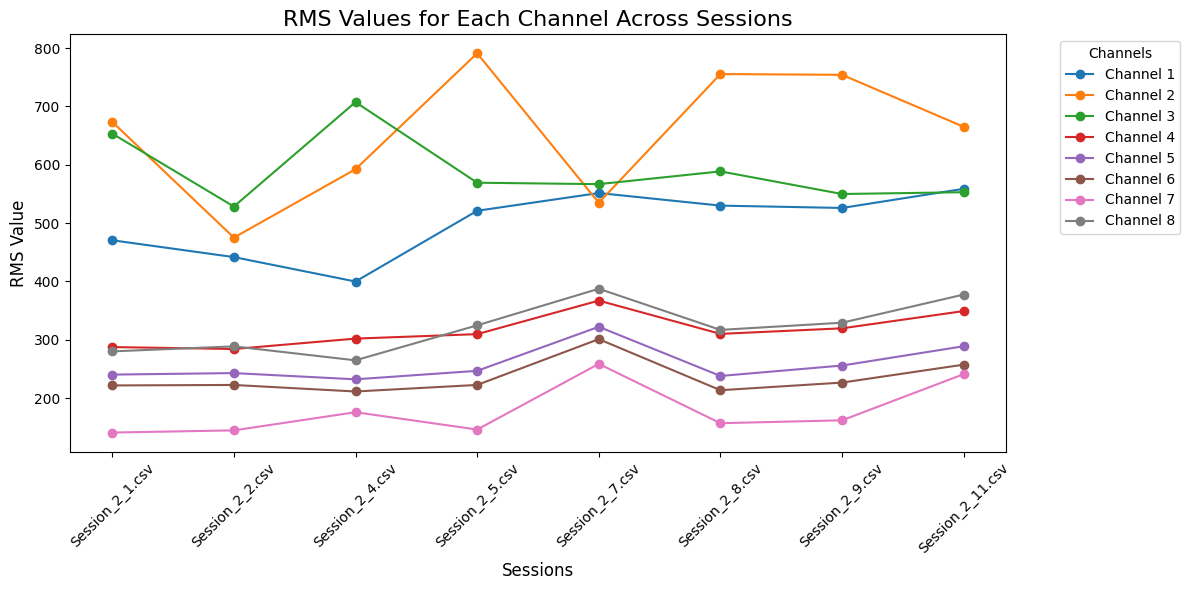

In [208]:
plot_rms_values(rms_results)

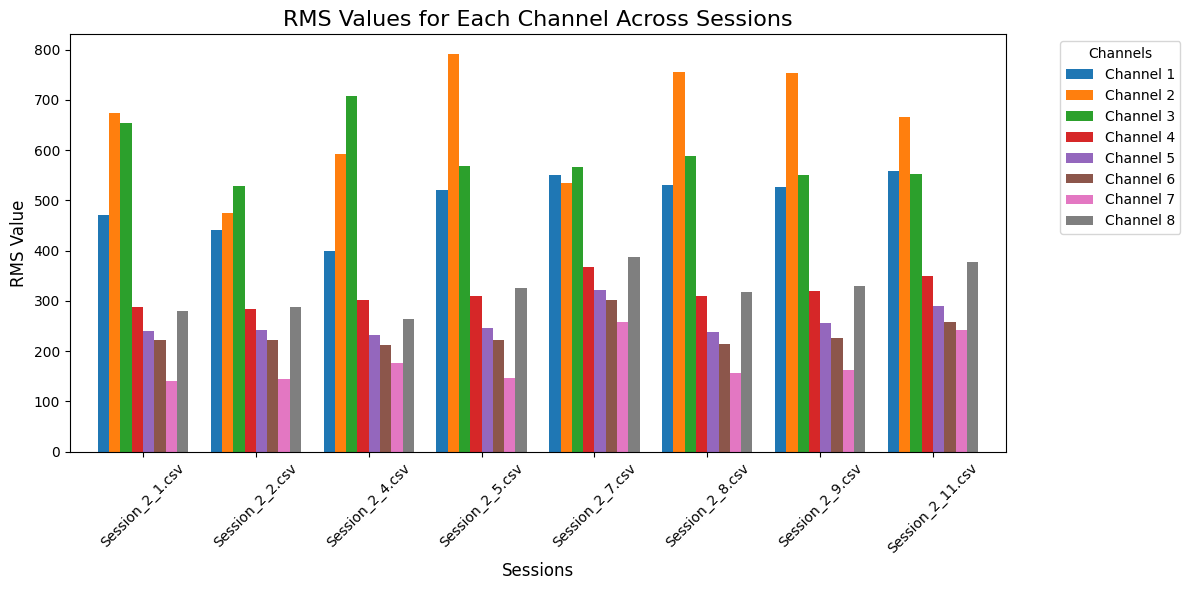

In [204]:
plot_rms_values(rms_results)

In [209]:
import numpy as np

def segment_data(data, window_size, step_size):
    """
    Segments the input data into windows.
    
    Parameters:
    - data: The sensor data (e.g., time-series).
    - window_size: The size of each window (e.g., 100 data points).
    - step_size: The step size for sliding the window (e.g., 50 data points).
    
    Returns:
    - A list of windows (sub-arrays).
    """
    # List to store the segments
    windows = []
    
    # Loop through the data and create windows
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
    
    return windows

# Example sensor data
sensor_data = np.array([i for i in range(1000)])  # Replace with actual sensor data

# Set parameters for window size and step size
window_size = 100  # Define window size (e.g., 100 data points)
step_size = 50     # Define step size (e.g., 50 data points)

# Segment the data
segmented_data = segment_data(sensor_data, window_size, step_size)

# Print the segmented windows
for i, window in enumerate(segmented_data):
    print(f"Window {i+1}: {window}")


Window 1: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Window 2: [ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149]
Window 3: [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 1

In [221]:
# Initialize the sensor data list
sensor = []
sensor_data = []

# Simulate receiving data from the sensor with increasing time points
time_points = [100, 100, 100, 100, 100]  # Example time points (0 to 100, 0 to 200, etc.)

for t in time_points:
    # Create a new data frame from 0 to the current time point t
    new_data = list(range(t))  # This generates data from 0 to t-1
    sensor_data.extend(new_data)  # Append the new data to the sensor data list
    sensor.append(sensor_data)
    # Print the current sensor data
    print(f"Sensor Data up to time point {t}: {sensor_data}")
    print()  # Blank line between frames




Sensor Data up to time point 100: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

Sensor Data up to time point 100: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,

In [223]:
import random

In [228]:
sensor = []
list_ = []
for i_data in range(10):
    x = random.sample(range(1, 50), 10)
    list_.extend(x)
    print(f"list_{list_}")
    sensor.append(list_)
    print(len(sensor[i_data]))
    
print(f"sensor_{sensor}")    

list_[11, 4, 40, 28, 1, 17, 24, 3, 31, 49]
10
list_[11, 4, 40, 28, 1, 17, 24, 3, 31, 49, 16, 10, 34, 44, 8, 19, 1, 27, 6, 41]
20
list_[11, 4, 40, 28, 1, 17, 24, 3, 31, 49, 16, 10, 34, 44, 8, 19, 1, 27, 6, 41, 17, 7, 12, 26, 22, 23, 43, 44, 21, 45]
30
list_[11, 4, 40, 28, 1, 17, 24, 3, 31, 49, 16, 10, 34, 44, 8, 19, 1, 27, 6, 41, 17, 7, 12, 26, 22, 23, 43, 44, 21, 45, 22, 5, 34, 20, 33, 32, 14, 31, 12, 7]
40
list_[11, 4, 40, 28, 1, 17, 24, 3, 31, 49, 16, 10, 34, 44, 8, 19, 1, 27, 6, 41, 17, 7, 12, 26, 22, 23, 43, 44, 21, 45, 22, 5, 34, 20, 33, 32, 14, 31, 12, 7, 48, 25, 16, 35, 39, 8, 3, 4, 33, 47]
50
list_[11, 4, 40, 28, 1, 17, 24, 3, 31, 49, 16, 10, 34, 44, 8, 19, 1, 27, 6, 41, 17, 7, 12, 26, 22, 23, 43, 44, 21, 45, 22, 5, 34, 20, 33, 32, 14, 31, 12, 7, 48, 25, 16, 35, 39, 8, 3, 4, 33, 47, 36, 15, 8, 1, 2, 45, 25, 10, 13, 19]
60
list_[11, 4, 40, 28, 1, 17, 24, 3, 31, 49, 16, 10, 34, 44, 8, 19, 1, 27, 6, 41, 17, 7, 12, 26, 22, 23, 43, 44, 21, 45, 22, 5, 34, 20, 33, 32, 14, 31, 12, 7, 4

In [ ]:
import time
import threading
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from collections import deque

# Assuming get_currentboard_data() is a function that provides real-time data from the sensor
def get_currentboard_data():
    # Simulate receiving data from an actual sensor (this is a placeholder function)
    # In practice, replace this with the actual sensor reading logic
    return [random.randint(1, 50) for _ in range(30)]  # Simulated data from the sensor

class RollingSensor:
    def __init__(self, num_points=100, window_size=10, step_size=20):
        # Initialize the buffer with the given size
        self.num_points = num_points
        self.window_size = window_size
        self.step_size = step_size  # Step size for window segmentation
        self.buffer = deque(maxlen=num_points)  # Deque automatically discards old data
        self.x_vals = []  # X-axis values for plotting
        self.y_vals = []  # Y-axis values for plotting
        self.window_lines = []  # List to store window lines for visualization
        self.new_data = []  # Placeholder for newly received data
        self.fig, self.ax = plt.subplots()  # Create the plot

    def update_buffer(self):
        # Get real data from the sensor using get_currentboard_data
        new_data = get_currentboard_data()
        self.new_data = new_data  # Store new data temporarily
        self.buffer.extend(new_data)  # Add new data to the buffer
        self.x_vals.extend(range(len(self.buffer)-len(new_data), len(self.buffer)))  # Update X-axis values
        self.y_vals.extend(new_data)  # Update Y-axis values

    def segment_buffer(self):
        # Only segment the buffer if it has enough data for at least one window
        window_segments = []
        if len(self.buffer) >= self.window_size:
            # Slide through the buffer and create windows of the specified size with step size
            for i in range(0, len(self.buffer) - self.window_size + 1, self.step_size):
                window = list(self.buffer)[i:i + self.window_size]
                window_segments.append((i, window))  # Store the start index and window data
        return window_segments

    def animate(self, frame):
        # Function called by FuncAnimation to update the plot in each frame
        self.update_buffer()  # Receive new data from the sensor
        window_segments = self.segment_buffer()  # Get the current window segments

        # Clear previous window lines and add new ones
        for line in self.window_lines:
            line.remove()  # Remove previous window lines
        self.window_lines.clear()

        # Plot the current data
        self.ax.clear()
        self.ax.plot(self.x_vals, self.y_vals, label='Sensor Data', color='blue')

        # Plot the window segments
        for i, window in window_segments:
            self.ax.plot(range(i, i + self.window_size), window, color='red', linewidth=2, alpha=0.5)

        self.ax.set_title('Real-time Sensor Data with Window Segmentation')
        self.ax.set_xlabel('Time (seconds)')
        self.ax.set_ylabel('Sensor Value')
        self.ax.legend()

    def run(self, duration=10):
        # Create the animation object
        ani = FuncAnimation(self.fig, self.animate, frames=range(int(duration * 10)), interval=100, repeat=False)

        # Display the plot
        plt.show()

# Example usage:
sensor = RollingSensor(num_points=100, window_size=50, step_size=20)  # Set the buffer size to 100, window size to 50, and step size to 20
sensor.run(duration=15)  # Run the sensor for 15 seconds


Window: [11, 12, 39, 38, 36, 44, 46, 21, 14, 39, 21, 10, 50, 20, 18, 36, 32, 20, 42, 37, 14, 31, 33, 28, 13, 14, 24, 49, 46, 42, 3, 7, 43, 15, 3, 5, 26, 16, 44, 50, 40, 12, 37, 12, 2, 4, 12, 10, 20, 2]: 1737162649.5042608
Window: [14, 31, 33, 28, 13, 14, 24, 49, 46, 42, 3, 7, 43, 15, 3, 5, 26, 16, 44, 50, 40, 12, 37, 12, 2, 4, 12, 10, 20, 2, 44, 9, 31, 49, 25, 45, 30, 42, 22, 30, 27, 19, 41, 33, 37, 5, 5, 25, 6, 37]: 1737162650.5048358
Window: [8, 26, 22, 7, 28, 30, 44, 21, 33, 3, 3, 36, 16, 28, 21, 25, 7, 22, 43, 21, 11, 12, 39, 38, 36, 44, 46, 21, 14, 39, 21, 10, 50, 20, 18, 36, 32, 20, 42, 37, 14, 31, 33, 28, 13, 14, 24, 49, 46, 42]: 1737162651.505669
Window: [11, 12, 39, 38, 36, 44, 46, 21, 14, 39, 21, 10, 50, 20, 18, 36, 32, 20, 42, 37, 14, 31, 33, 28, 13, 14, 24, 49, 46, 42, 3, 7, 43, 15, 3, 5, 26, 16, 44, 50, 40, 12, 37, 12, 2, 4, 12, 10, 20, 2]: 1737162652.5064492
Window: [14, 31, 33, 28, 13, 14, 24, 49, 46, 42, 3, 7, 43, 15, 3, 5, 26, 16, 44, 50, 40, 12, 37, 12, 2, 4, 12, 10, 

In [250]:
import time
import threading
import random
import matplotlib.pyplot as plt
from collections import deque

# Assuming get_currentboard_data() is a function that provides real-time data from the sensor
def get_currentboard_data():
    # Simulate receiving data from an actual sensor (this is a placeholder function)
    # In practice, replace this with the actual sensor reading logic
    return [random.randint(1, 50) for _ in range(30)]  # Simulated data from the sensor

class RollingSensor:
    def __init__(self, num_points=100, window_size=10, step_size=20):
        # Initialize the buffer with the given size
        self.num_points = num_points
        self.window_size = window_size
        self.step_size = step_size  # Step size for window segmentation
        self.buffer = deque(maxlen=num_points)  # Deque automatically discards old data
        self.running = True  # Flag to control the running state
        self.fig, self.ax = plt.subplots()  # Create the plot
        self.x_vals = []  # X-axis values for plotting
        self.y_vals = []  # Y-axis values for plotting
        self.window_lines = []  # List to store window lines for visualization

    def update_buffer(self):
        # Get real data from the sensor using get_currentboard_data
        new_data = get_currentboard_data()
        self.buffer.extend(new_data)  # Add new data to the buffer using extend
        self.x_vals.extend(range(len(self.buffer)-len(new_data), len(self.buffer)))  # Update X-axis values
        self.y_vals.extend(new_data)  # Update Y-axis values
        print(f"New data received: {new_data}")
        # No need to wait for segmentation to be complete; it runs concurrently

    def segment_buffer(self):
        # Only segment the buffer if it has enough data for at least one window
        while self.running:  # Keep running until explicitly stopped
            if len(self.buffer) >= self.window_size:
                # Slide through the buffer and create windows of the specified size with step size
                for i in range(0, len(self.buffer) - self.window_size + 1, self.step_size):
                    window = list(self.buffer)[i:i + self.window_size]
                    # Highlight the window in the plot
                    window_line, = self.ax.plot(range(i, i + self.window_size), window, color='red', linewidth=2)
                    self.window_lines.append(window_line)
                    print(f"Window: {window}")
                    time.sleep(1)  # Simulate window processing time

    def plot_data(self):
        # Plot the buffer data in real-time
        self.ax.clear()  # Clear the axis to prevent overplotting
        self.ax.plot(self.x_vals, self.y_vals, label='Sensor Data', color='blue')
        # Draw the window lines
        for window_line in self.window_lines:
            window_line.set_alpha(0.5)  # Set the transparency of the window lines
        self.ax.set_title('Real-time Sensor Data with Window Segmentation')
        self.ax.set_xlabel('Time (seconds)')
        self.ax.set_ylabel('Sensor Value')
        self.ax.legend()
        plt.draw()
        plt.pause(0.1)  # Pause to allow the plot to update

    def run(self, duration=10):
        # Run the sensor for a given duration (in seconds)
        start_time = time.time()

        # Start window segmentation in a separate thread
        segment_thread = threading.Thread(target=self.segment_buffer)
        segment_thread.start()

        while time.time() - start_time < duration:
            self.update_buffer()  # Continue receiving data every 0.1s
            self.plot_data()  # Plot the data in real-time
            time.sleep(0.1)  # Simulate receiving new data every 0.1 seconds

        # Stop the segmentation thread after the duration
        self.running = False
        segment_thread.join()  # Ensure the segmentation thread finishes cleanly
        plt.show()  # Show the plot after the simulation ends

# Example usage:
sensor = RollingSensor(num_points=100, window_size=50, step_size=20)  # Set the buffer size to 100, window size to 50, and step size to 20
sensor.run(duration=15)  # Run the sensor for 15 seconds


New data received: [2, 15, 33, 43, 49, 1, 16, 15, 4, 35, 41, 6, 24, 50, 43, 2, 3, 30, 3, 46, 17, 6, 42, 36, 2, 18, 13, 26, 3, 44]


KeyboardInterrupt: 

EXP

In [ ]:
def segment_data(data, window_size, step_size):

    windows = []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
    return windows



# Combine all the data into a single array (this assumes continuous data)
combined_data = np.concatenate(sensor)  # Combine all intervals into one continuous array

# Set parameters for window size and step size
window_size = 10  # Define window size (e.g., 10 data points)
step_size = 5     # Define step size (e.g., 5 data points)

# Apply window segmentation
segmented_data = segment_data(combined_data, window_size, step_size)

# Print segmented windows
for i, window in enumerate(segmented_data):
    print(f"Window {i+1}: {window}")


In [112]:
filtered_df['Channel 1'] = filtered_df['Channel 1'].rolling(window=50).mean()

print(filtered_df['Channel 1'])

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
34963    80.599695
34964    80.152618
34965    79.713770
34966    79.292446
34967    78.873204
Name: Channel 1, Length: 34968, dtype: float64


In [109]:
from scipy.signal import find_peaks

In [113]:
peaks,_ = find_peaks(filtered_df[filtered_df.columns[0]])

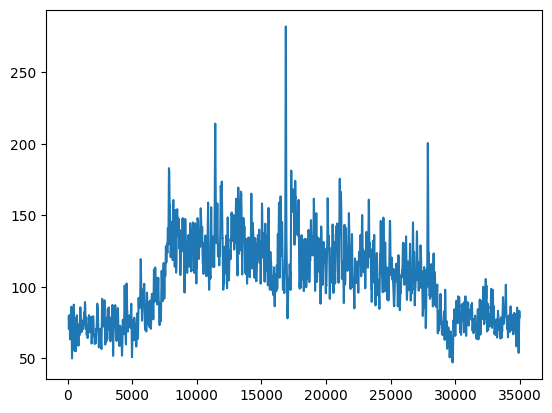

In [118]:
plt.plot(filtered_df[filtered_df.columns[0]])

In [91]:
peak_data_list = []

In [94]:
for i in range(len(filtered_df)):
    chan = filtered_df[filtered_df.columns[i]]
    peaks,_ = find_peaks(chan)
    peak_data_list.append(peaks)

IndexError: index 8 is out of bounds for axis 0 with size 8